In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os import listdir

In [2]:
data_path='mit-bih-arrhythmia-database-1.0.0/'

In [3]:
pts = ['100', '101', '102','103', '104', '105', '106', '107', '108', '109', '111','112', '113', '114', '115', '116', '117','118','119','121','122','123','124','200',
'201', '202', '203', '205', '207', '208', '209', '210', '212', '213', '214', '215','217', '219', '220', '221','222','223' ,'228','230','231','232','233','234']

In [4]:
pip install wfdb

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install .

Processing d:\mtu course files\sem 4\cdss\assignment 5\mit-bih-arrhythmia-database-1.0.0
  Created wheel for wfdb: filename=wfdb-2.2.1-cp37-none-any.whl size=95042 sha256=6f1b3fba5e857454cfac5427436feb165c35ed861d29518a68081800a1427ad5
  Stored in directory: C:\Users\sneha\AppData\Local\pip\Cache\wheels\6a\4d\b5\a248a0fad3a021082a64a31ba5ee638fc21ea02dd5cbac8214
Successfully built wfdb
  Found existing installation: wfdb 2.2.1
    Uninstalling wfdb-2.2.1:
      Successfully uninstalled wfdb-2.2.1
Note: you may need to restart the kernel to use updated packages.


In [6]:
import wfdb

In [7]:
df = pd.DataFrame()
for pt in pts:
    file = data_path+pt
    annotation=wfdb.rdann(file, 'atr')
    sym=annotation.symbol
    values, counts=np.unique(sym, return_counts=True)
    df_sub=pd.DataFrame({'sym':values,'val':counts,'pt':[pt]*len(counts)})
    df=pd.concat([df,df_sub],axis=0)

In [8]:
df.groupby('sym').val.sum().sort_values(ascending = False)

sym
N    75052
L     8075
R     7259
V     7130
/     7028
A     2546
+     1291
f      982
F      803
~      616
!      472
"      437
j      229
x      193
a      150
|      132
E      106
J       83
Q       33
e       16
[        6
]        6
S        2
Name: val, dtype: int64

In [9]:
nonbeat = ['[','!',']','x','(',')','p','t','u','`','\'','^','|','~','+','s','T','*','D','=','"','@','Q','?']
abnormal=['L','R','V','/','A','f','F','j','a','E','J','e','S']

In [10]:
df['cat'] = -1
df.loc[df.sym == 'N', 'cat'] = 0
df.loc[df.sym.isin(abnormal),'cat']=1

In [11]:
df.groupby('cat').val.sum()

cat
-1     3186
 0    75052
 1    34409
Name: val, dtype: int64

In [12]:
def load_ecg(file):
    record = wfdb.rdrecord(file)
    annotation=wfdb.rdann(file, 'atr')
    p_signal=record.p_signal
    assert record.fs == 360, 'sample fre is not 360'
    atr_sym = annotation.symbol
    atr_sample = annotation.sample
    return p_signal, atr_sym, atr_sample

In [13]:
file = data_path + pts[0]

In [14]:
p_signal, atr_sym, atr_sample = load_ecg(file)

In [15]:
values, counts = np.unique(sym, return_counts = True)
for v,c in zip(values, counts):
    print(v,c)

+ 3
J 50
N 2700
V 3
~ 8


In [16]:
ab_index = [b for a,b in zip(atr_sym, atr_sample) if a in abnormal][:10]
ab_index

[2044, 66792, 74986, 99579, 128085, 170719, 279576, 305709, 307745, 312825]

In [17]:
x = np.arange(len(p_signal))

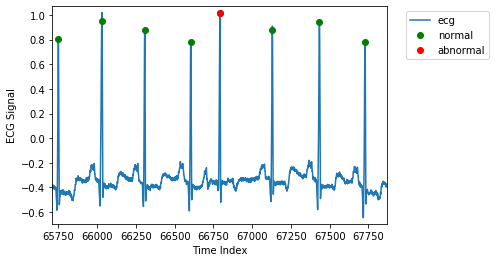

In [19]:
left = ab_index[1]-1080
right = ab_index[1]+1080

plt.plot(x[left:right],p_signal[left:right,0], '-', label = 'ecg')
plt.plot(x[atr_sample],p_signal[atr_sample,0], 'go', label = 'normal')
plt.plot(x[ab_index],p_signal[ab_index,0],'ro', label='abnormal')

plt.xlim(left, right)
plt.ylim(p_signal[left:right].min()-0.05,p_signal[left:right,0].max()+0.05)
plt.xlabel('Time Index')
plt.ylabel('ECG Signal')
plt.legend(bbox_to_anchor = (1.04,1),loc = 'upper left')
plt.show()

In [20]:
def make_dataset(pts, num_sec, fs):
    num_cols = 2*num_sec*fs
    X_all = np.zeros((1,num_cols))
    Y_all = np.zeros((1,1))
    sym_all = []
    abnormal=['L','R','V','/','A','f','F','j','a','E','J','e','S']
    
    max_rows = []
    
    for pt in pts:
        file = data_path+pt
        p_signal,atr_sym,atr_sample = load_ecg(file)
        p_signal = p_signal[:,0]
        df_ann = pd.DataFrame({'atr_sym':atr_sym, 'atr_sample':atr_sample})
        df_ann = df_ann.loc[df_ann.atr_sym.isin(abnormal+['N'])]
        num_rows = len(df_ann)
        
        X = np.zeros((num_rows, num_cols))
        Y = np.zeros((num_rows,1))
        
        max_row = 0
        
        for atr_sample, atr_sym in zip(df_ann.atr_sample.values,df_ann.atr_sym.values):
            left = max([0,(atr_sample - num_sec*fs) ])
            right = min([len(p_signal),(atr_sample + num_sec*fs) ])
            x = p_signal[left: right]
            if len(x) == num_cols:
                X[max_row,:] = x
                Y[max_row,:] = int(atr_sym in abnormal)
                sym_all.append(atr_sym)
                max_row += 1
        X = X[:max_row,:]
        Y = Y[:max_row,:]
        max_rows.append(max_row)
        X_all = np.append(X_all,X,axis = 0)
        Y_all = np.append(Y_all,Y,axis = 0)
    # drop the first zero row
    X_all = X_all[1:,:]
    Y_all = Y_all[1:,:]
    # check sizes make sense
    assert np.sum(max_rows) == X_all.shape[0], 'number of rows messed up'
    assert Y_all.shape[0] == X_all.shape[0], 'number of rows messed up'
    assert Y_all.shape[0] == len(sym_all), 'number of rows messed up'
    return X_all, Y_all, sym_all
        

        

In [21]:
num_sec = 3
fs = 360

In [22]:
X_all, Y_all, sym_all = make_dataset(pts,num_sec,fs)

In [23]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X_all, Y_all, test_size = 0.33, random_state = 42)

In [27]:
pip install keras

Note: you may need to restart the kernel to use updated packages.


In [32]:
pip install tensorflow

  Using cached https://files.pythonhosted.org/packages/34/d5/ce8c17971067c0184c9045112b755be5461d5ce5253ef65a367e1298d7c5/tensorflow-2.1.0-cp37-cp37m-win_amd64.whl
  Using cached https://files.pythonhosted.org/packages/c3/88/97eef84f48fa04fbd6750e62dcceafba6c63c81b7ac1420856c8dcc0a3f9/astor-0.8.1-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/d9/41/bbf49b61370e4f4d245d4c6051dfb6db80cec672605c91b1652ac8cc3d38/tensorboard-2.1.1-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/18/90/b77c328a1304437ab1310b463e533fa7689f4bfc41549593056d812fab8e/tensorflow_estimator-2.1.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/a7/6d/99aba8db04bf58193ed157dfe7e848494b93dd8aa3f6a4d1edfef318779c/grpcio-1.27.2-cp37-cp37m-win_amd64.whl
  Using cached https://files.pythonhosted.org/packages/a3/de/c648ef6835192e6e2cc03f40b19eeda4382c49b5bafb43d88b931c4c74ac/google_pasta-0.2.0-py3-none-any.whl
  Using cached https://files.python

In [33]:
import random
import tensorflow as tf    
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.utils import to_categorical


In [34]:
model = Sequential()
model.add(Dense(32,activation = 'relu', input_dim = X_train.shape[1]))
model.add(Dropout(rate=0.25))
model.add(Dense(1,activation='sigmoid'))

In [35]:
model.compile(loss = 'binary_crossentropy', optimizer = 'adam',metrics=['accuracy'])

In [36]:
model.fit(X_train,y_train,batch_size=32, epochs = 5, verbose = 1)

Train on 73096 samples
Epoch 1/5
73096/73096 [==============================] - 9s 129us/sample - loss: 0.2521 - accuracy: 0.9054
Epoch 2/5
73096/73096 [==============================] - 8s 108us/sample - loss: 0.1633 - accuracy: 0.9460
Epoch 3/5
73096/73096 [==============================] - 8s 115us/sample - loss: 0.1442 - accuracy: 0.9536
Epoch 4/5
73096/73096 [==============================] - 8s 113us/sample - loss: 0.1362 - accuracy: 0.9571
Epoch 5/5
73096/73096 [==============================] - 8s 114us/sample - loss: 0.1273 - accuracy: 0.9608


In [37]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score
def calc_prevalence(y_actual):
    return(sum(y_actual)/len(y_actual))
def calc_specificity(y_actual,y_pred,thresh):
    return sum((y_pred<thresh) & (y_actual == 0)) / sum(y_actual ==0)
def print_report(y_actual,y_pred,thresh):
    auc = roc_auc_score(y_actual,y_pred)
    accuracy = accuracy_score(y_actual,(y_pred>thresh))
    recall = recall_score(y_actual,(y_pred>thresh))
    precision = precision_score(y_actual,(y_pred>thresh))
    specificity = calc_specificity(y_actual, y_pred, thresh)
    print('AUC:%.3f'%auc)
    print('accuracy:%.3f'%accuracy)
    print('recall:%.3f'%recall)
    print('precision:%3f'%precision)    
    print('specificity:%3f'%specificity)    
    print('prevalence:%3f'%calc_prevalence(y_actual))
    print('')
    return auc, accuracy, recall, precision, specificity

In [38]:
y_train_preds_dense = model.predict_proba(X_train,verbose =1)
y_valid_preds_dense = model.predict_proba(X_valid,verbose =1)

36003/36003 [==============================] - 2s 65us/sample


In [39]:
thresh = (sum(y_train)/len(y_train))[0]
thresh

0.3147641457808909

In [40]:
print('Train');
print_report(y_train, y_train_preds_dense, thresh)
print('Valid');
print_report(y_valid, y_valid_preds_dense, thresh);

Train
AUC:0.992
accuracy:0.965
recall:0.961
precision:0.931248
specificity:0.967397
prevalence:0.314764

Valid
AUC:0.988
accuracy:0.959
recall:0.953
precision:0.920315
specificity:0.962278
prevalence:0.313752



In [42]:
import random
random.seed(42)
pts_train = random.sample(pts,36)
pts_valid = [pt for pt in pts if pt not in pts_train]
print(len(pts_train),len(pts_valid))

36 12


In [43]:
X_train, y_train, sym_train = make_dataset(pts_train,num_sec,fs)
X_valid, y_valid, sym_valid = make_dataset(pts_valid, num_sec,fs)
print(X_train.shape, y_train.shape, len(sym_train))
print(X_valid.shape, y_valid.shape,len(sym_valid))

(80614, 2160) (80614, 1) 80614
(28485, 2160) (28485, 1) 28485


In [44]:
## New Dense Model:

model = Sequential()
model.add(Dense(32,activation = 'relu', input_dim = X_train.shape[1]))
model.add(Dropout(rate=0.25))
model.add(Dense(1,activation = 'sigmoid'))

model.compile(loss = 'binary_crossentropy',optimizer='adam',metrics = ['accuracy'] )

model.fit(X_train, y_train, batch_size = 32, epochs = 5, verbose = 1)

Train on 80614 samples
Epoch 1/5
80614/80614 [==============================] - 17s 210us/sample - loss: 0.2266 - accuracy: 0.9190
Epoch 2/5
80614/80614 [==============================] - 15s 186us/sample - loss: 0.1469 - accuracy: 0.9563
Epoch 3/5
80614/80614 [==============================] - 13s 163us/sample - loss: 0.1288 - accuracy: 0.9622
Epoch 4/5
80614/80614 [==============================] - 14s 172us/sample - loss: 0.1194 - accuracy: 0.9656
Epoch 5/5
80614/80614 [==============================] - 12s 147us/sample - loss: 0.1119 - accuracy: 0.9672


In [45]:
y_train_preds_dense = model.predict_proba(X_train, verbose =1)
y_valid_preds_dense = model.predict_proba(X_valid, verbose =1)


28485/28485 [==============================] - 2s 66us/sample


In [46]:
thresh = (sum(y_train)/len(y_train))[0]
thresh

0.29906715955045027

In [47]:
print('Train');
print_report(y_train,y_train_preds_dense, thresh);
print('Valid');
print_report(y_valid,y_valid_preds_dense, thresh);

Train
AUC:0.993
accuracy:0.970
recall:0.964
precision:0.936714
specificity:0.972215
prevalence:0.299067

Valid
AUC:0.850
accuracy:0.770
recall:0.450
precision:0.830769
specificity:0.948879
prevalence:0.357908



In [63]:
aucs_train = []
aucs_valid = []

n_pts = [1,18,36]

for n_pt in n_pts:
    print(n_pt)
    pts_sub = pts_train[:n_pt]
    X_sub, y_sub, sym_sub = make_dataset(pts_sub, num_sec, fs)
    model = Sequential()
    model.add(Dense(32, activation = 'relu', input_dim = X_train.shape[1]))
    model.add(Dropout(rate=0.25))
    model.add(Dense(1,activation = 'sigmoid'))
    model.compile(loss = 'binary_crossentropy',optimizer='adam',metrics = ['accuracy'] )
    model.fit(X_sub, y_sub, batch_size = 32, epochs = 5, verbose =0)
    y_sub_preds_dense = model.predict_proba(X_sub, verbose = 0)
    y_valid_preds_dense = model.predict_proba(X_valid, verbose =0)
    
    auc_train = roc_auc_score(y_sub,y_sub_preds_dense)
    auc_valid = roc_auc_score(y_valid, y_valid_preds_dense)
    print('-', auc_train, auc_valid)
    aucs_train.append(auc_train)
    aucs_valid.append(auc_valid)
    
    


1
- 0.9272578336783087 0.6970590328399383
18
- 0.9951005291156473 0.8321804956438565
36
- 0.9932850222327249 0.8460329453191471


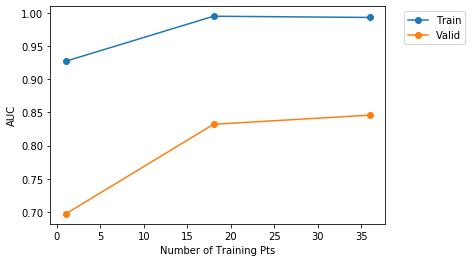

In [66]:
plt.plot(n_pts, aucs_train, 'o-', label = 'Train')
plt.plot(n_pts, aucs_valid, 'o-', label = 'Valid')
plt.xlabel('Number of Training Pts')
plt.ylabel('AUC')
plt.legend(bbox_to_anchor = (1.04, 1), loc = 'upper left')
plt.show()

In [67]:
X_train_cnn = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1)) 
X_valid_cnn = np.reshape (X_valid, (X_valid.shape[0], X_valid.shape[1], 1))

print(X_train_cnn.shape) 
print(X_valid_cnn.shape)

(80614, 2160, 1)
(28485, 2160, 1)


In [81]:
from keras.layers import Conv1D
from keras.layers import Flatten

from keras.layers import Dense, Embedding, Dropout, LSTM
from keras.models import Sequential
from keras.layers import Bidirectional
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

In [82]:
model = Sequential() 
model.add(Conv1D(filters = 128, kernel_size = 5, activation='relu', input_shape = (2160,1))) 
model.add(Dropout (rate = 0.25)) 
model.add(Flatten()) 
model.add(Dense(1, activation = 'sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer =  'adam', metrics = ['accuracy'])

In [83]:
model.fit(X_train_cnn, y_train, batch_size = 32, epochs=2, verbose = 1)

Epoch 1/2
80614/80614 [==============================] - 555s 7ms/step - loss: 0.1965 - accuracy: 0.9346
Epoch 2/2
80614/80614 [==============================] - 534s 7ms/step - loss: 0.1169 - accuracy: 0.9658


In [84]:
y_train_preds_cnn = model.predict_proba(X_train_cnn, verbose = 1)
y_valid_preds_cnn = model.predict_proba(X_valid_cnn, verbose = 1)

28485/28485 [==============================] - 29s 1ms/step


In [85]:
print('Train');
print_report(y_train, y_train_preds_cnn, thresh);
print('Valid');
print_report(y_valid, y_valid_preds_cnn, thresh);

Train
AUC:0.986
accuracy:0.967
recall:0.927
precision:0.962850
specificity:0.984745
prevalence:0.299067

Valid
AUC:0.916
accuracy:0.853
recall:0.704
precision:0.860841
specificity:0.936523
prevalence:0.357908



In [86]:
from keras.layers import Bidirectional, LSTM

In [87]:
model = Sequential()
model.add(Bidirectional(LSTM(64, input_shape = (X_train_cnn.shape[1], X_train_cnn.shape[2]))))
model.add(Dropout(rate=0.25))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])

In [88]:
model.fit(X_train_cnn[:10000], y_train[:10000], batch_size = 32, epochs =1, verbose = 1)

Epoch 1/1
10000/10000 [==============================] - 775s 77ms/step - loss: 0.5916 - accuracy: 0.6881


In [91]:
y_train_preds_lstm = model.predict_proba(X_train_cnn[:10000], verbose = 1)
y_valid_preds_lstm = model.predict_proba(X_valid_cnn, verbose = 1)

28485/28485 [==============================] - 259s 9ms/step


In [92]:
print('Train');
print_report(y_train[:10000], y_train_preds_lstm, thresh);
print('Valid');
print_report(y_valid, y_valid_preds_lstm, thresh);

Train
AUC:0.778
accuracy:0.679
recall:0.899
precision:0.617903
specificity:0.467802
prevalence:0.489100

Valid
AUC:0.470
accuracy:0.526
recall:0.347
precision:0.341047
specificity:0.626353
prevalence:0.357908

